## Introduction
This notebook guides the user step-by-step through the general workflow with Nook’iin, from loading libraries to visualizing the reciprocal space and diffraction pattern. It is ideal for understanding the full use of the tool before reviewing more specific examples.

## Loading Libraries and Packages
The first step in using the Nook’iin tool to obtain the minimal cell of a stacked 2D system is to load all the required libraries by importing the System file from the src folder.

In [1]:
import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from System import *

Nook'iin Ready-to-work


## Creating 2D Lattices
Lattice objects model the crystals that make up the system we want to simulate. There are two ways to create lattices:

Manual creation: the primitive vectors (PVs) and the atomic basis (a list of Atom objects with their relative positions to the PVs) are defined explicitly.

Assisted creation: functions such as hexa3(), hexa6(), or rectLattice() are used to generate lattices with hexagonal (S3, S6) or rectangular symmetry. There are also predefined functions like graphene(), grapheneC3(), blackPhosphorene(), and h_BN().

Below is an example of how to manually build the lattice of beta-GeSe:

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
b-GeSe
1.0
        3.8261001110         0.0000000000         0.0000000000
        0.0000000000         5.8088998795         0.0000000000
        0.0000000000         0.0000000000         18.0892009735
	Ge	Se
	2	2
Direct
         0.7500000000         0.3677821160         0.1606478230
         0.2500000000         0.8684009310         0.0634941810
         0.7500000000         0.8466233610         0.1609372630
         0.2500000000         0.3469434380         0.0631845500
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


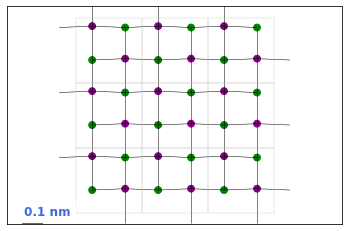

In [2]:
# Define the relative positions of the atoms in the atomic basis
pos1,pos2,pos3,pos4=(0.750000000,0.367782116),(0.250000000,0.868400931),(0.750000000,0.846623361),(0.250000000,0.346943438)

# Initialize the atoms
atomos=[Atom(pos1,posZ=0.160547823,color='purple',sig='Ge'),
        Atom(pos2,posZ=0.063394181,color='purple',sig='Ge'),
        Atom(pos3,posZ=0.160837263,color='green',sig='Se'),
        Atom(pos4,posZ=0.063084550,color='green',sig='Se')]

# Optional bonding for visualization
enlaces=[(pos1,pos3),(pos1,pos4),(pos1,sumaV(pos4,(1,0))),(pos1,sumaV(pos3,(0,-1))),
         (pos2,pos4),(pos2,pos3),(pos2,sumaV(pos3,(-1,0))),(pos2,sumaV(pos4,(0,1)))]

# Primitive vectors
vA, vB = (3.8261001110,0.0000000000), (0.0000000000,5.8088998795)

# Lattice initialization
bGeSe = Lattice(vA,vB,atms=atomos,enls=enlaces,detachment=18.0892009735,name='b-GeSe')

# Lattice initialization
print("+-"*40+"\n"+bGeSe.showData()+"\n"+"+-"*40)
bGeSe.showme(x=3,y=3)

It is also possible to import lattices from POSCAR files, in this case from the FePS3 and graphene files in a /VASP-FILES folder:

File 'C:\SS\Nook’iin\Nook-iin\VASP_Files/FePS3.vasp' will be read
--Lattice created successfully from file 'C:\SS\Nook’iin\Nook-iin\VASP_Files/FePS3.vasp'--
File 'C:\SS\Nook’iin\Nook-iin\VASP_Files/graphene.vasp' will be read
--Lattice created successfully from file 'C:\SS\Nook’iin\Nook-iin\VASP_Files/graphene.vasp'--
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
FePS3
1.0
        5.9314999580         0.0000000000         0.0000000000
        -2.9657499790         5.1368296462         0.0000000000
        0.0000000000         0.0000000000         20.0000000000
	Fe	P	S
	2	2	6
Direct
         0.0000000000         0.0000000000         0.5001000000
         0.6666666870         0.3333333430         0.5001000000
         0.3333333430         0.6666666870         0.4451491070
         0.3333333430         0.6666666870         0.5550508930
         0.3333333430         0.3302960990         0.4212900530
         0.3333333430         0.0030372400         0.578

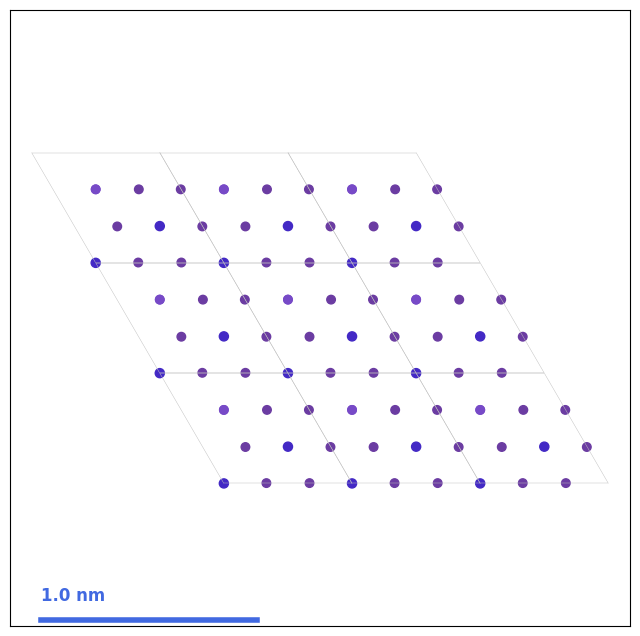

+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Graphene
1.0
        2.4672000408         0.0000000000         0.0000000000
        -1.2336000204         2.1366579116         0.0000000000
        0.0000000000         0.0000000000         5.0000000000
	C
	2
Direct
         0.3333333430         0.6666666870         0.1001000000
         0.6666666870         0.3333333430         0.1001000000
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


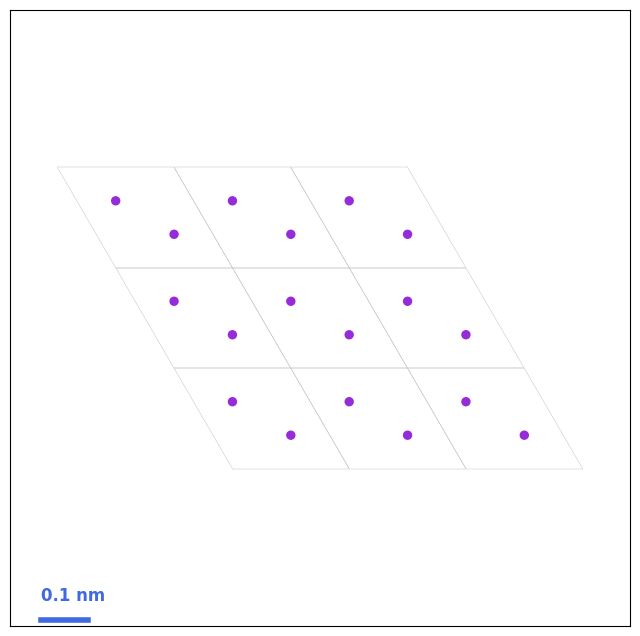

In [3]:
VASP_Files = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'VASP_Files'))
# Import from POSCAR-type files (in 'direct' format)
l1 = importLattice(VASP_Files+"/FePS3")
l2 = importLattice(VASP_Files+"/graphene")

# Assign names
l1.name="FePS3"
l2.name="Graphene"

# Visualization
print("+-"*40+"\n"+l1.showData()+"\n"+"+-"*40)
l1.showme(x=3,y=3)
print("+-"*40+"\n"+l2.showData()+"\n"+"+-"*40)
l2.showme(x=3,y=3)

## Solving for the Primitive Cell of a System
### System Initialization
The first step is to model the system by initializing a System object from a list of lattices.

If needed, we can apply a rotation to any of the layers using the mRot(θ) function.

For this example, we will model a system formed by stacking FePS3 and graphene with a relative rotation of $24.07^\circ$ between them, using the already imported lattices.

In [4]:
sr = System([l1, l2.mRot(24.07)])

### Primitive Cell (PC) Search
Once the system is modeled, we can search for a primitive cell (PC) using:

 - searchLP(rangeOfSearch, epsilon): generates possible primitive vectors
 - calculateTM(): generates the corresponding transformation matrices
 - ShowTMs(): displays tables with the suggested PCs

We will now search for possible PCs for the defined system within a search area equivalent to a radius of 10 times the FePS3 PC (rangeOfSearch=10) and with a maximum accepted strain of approximately 1% (epsilon=0.01).

Finally, we will examine the Transformation Matrices (TMs) corresponding to the possible calculated PCs.

In [5]:
sr.searchLP(rangeOfSearch=10, epsilon=0.01)
sr.calculateTM()
sr.ShowTMs()


***Option 1: T <- Matrix loMat[0]
Size of the primitive vectors: |a|=33.02519Å, |b|=33.02519Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   6   -1|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  310   |
|          FePS3          |  |   1    5|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |  11    4|  |  | 0.99293  0.00403|  |   -0.505% // -0.2°    |  362   |
|    Graphene(24.07°)     |  |  -4   15|  |  |-0.00403  0.99696|  |   -0.505% // -0.2°    |        |
|                         |               |                      

[[9, 5], [-5, 14]]

### Highlighted Results
After analyzing the results, two stand out. The first is the one suggested by the program, as it produces the least distortion in the graphene layer. The second generates the smallest PC.

------------------------------------------------------------------------------------
##### <center>Resultado sugerido<center>
|$$\text{Lattice}$$|$$\text{T}$$|$$\text{M.Deformation}$$|$$\text{delta//theta}$$|$$\text{\#Atoms}$$|
|-------|-|-------------|------------|--------|
|FePS3|$$\begin{matrix}9&5\\-5&14\end{matrix}$$|$$\begin{matrix}1&0\\0&1\end{matrix}$$|$$\begin{matrix}0.000\%\text{  }//\text{  }0.0^o\\0.000\%\text{  }//\text{  }0.0°\end{matrix}$$|1510|
|Graphene(24.07°)|$$\begin{matrix}-9&24\\-24&33\end{matrix}$$|$$\begin{matrix}0.99988&-0.00003\\0.00003&0.99985\end{matrix}$$|$$\begin{matrix}-0.013\%\text{  }//\text{  }0.0^o\\-0.013\%\text{  }//\text{  }0.0^o\end{matrix}$$|1746|

---------------------------------------------------------------------------------
##### <center>Resultado más pequeño<center>
|$$\text{Lattice}$$|$$\text{T}$$|$$\text{M.Deformation}$$|$$\text{delta//theta}$$|$$\text{\#Atoms}$$|
|-------|-|-------------|------------|--------|
|FePS3|$$\begin{matrix}6&-1\\1&5\end{matrix}$$|$$\begin{matrix}1&0\\0&1\end{matrix}$$|$$\begin{matrix}0.000\%\text{  }//\text{  }0.0^o\\0.000\%\text{  }//\text{  }0.0°\end{matrix}$$|310|
|Graphene(24.07°)|$$\begin{matrix}11&-4\\4&15\end{matrix}$$|$$\begin{matrix}0.99293&0.00403\\-0.00403&0.99696\end{matrix}$$|$$\begin{matrix}-0.505\%\text{  }//\text{  }-0.2^o\\-0.505\%\text{  }//\text{  }-0.2^o\end{matrix}$$|362|

----------------------------------------------------------------------------------
With the first result, the number of atoms is $3256$, with a reduction in the length of the primitive vectors of the second layer by only $0.013\%$. The second, at the cost of a $0.505\%$ reduction and a correction of $-0.2^\circ$ in its PV angles, reduces this number to $672$.

We will now create systems using both results to display them, starting with the suggested result.
Let's begin with the one corresponding to the smallest PC:

Size of the primitive vectors: |a|=33.02519Å, |b|=33.02519Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   6   -1|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  310   |
|          FePS3          |  |   1    5|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |  11    4|  |  | 0.99293  0.00403|  |   -0.505% // -0.2°    |  362   |
|    Graphene(24.07°)     |  |  -4   15|  |  |-0.00403  0.99696|  |   -0.505% // -0.2°    |        |
|                         |               |                       |                       |        |

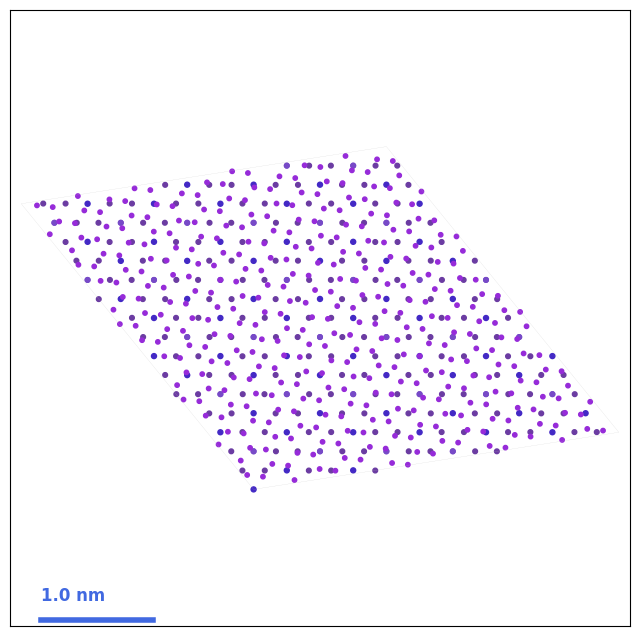

Image address: 'C:\SS\Nook’iin\Nook-iin\Examples\English\Images/FePS3-Grahene24_07-A(3x3).png'


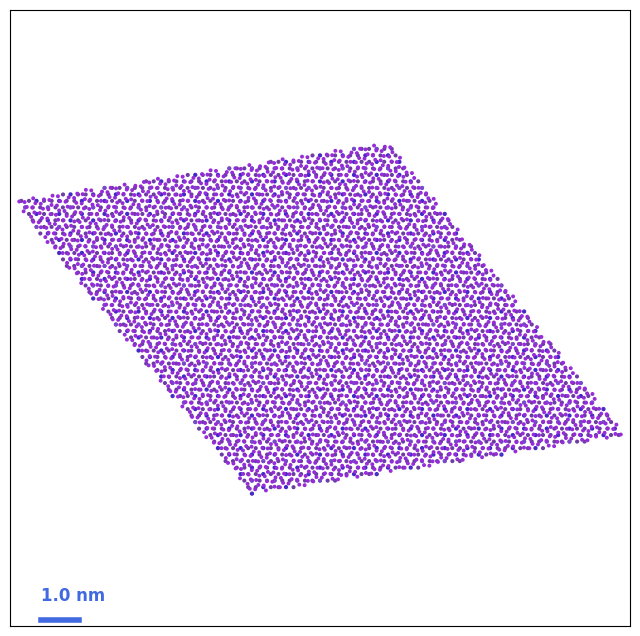

In [6]:
sMi,D = sr.optimize_system(sr.loMat[0],prnt=False)
sr.leeMT(sr.loMat[0])
sMi.SuperRed.showme(t=3)
sMi.SuperRed.showme(x=3,y=3,t=1, iName='FePS3-Grahene24_07-A(3x3)')

Result with least distortion:

Size of the primitive vectors: |a|=72.88749Å, |b|=72.88749Å
Angle between vectors: 120.000°
+-------------------------+---------------+-----------------------+-----------------------+--------+
|         Lattice         |       T       |      Deformation      |    Distortion:δ//θ    | #Atoms |
+-------------------------+---------------+-----------------------+-----------------------+--------+
|                         |  |   9    5|  |  | 1.00000  0.00000|  |    +0.0% // +0.0°     |  1510  |
|          FePS3          |  |  -5   14|  |  | 0.00000  1.00000|  |    +0.0% // +0.0°     |        |
|                         |               |                       |                       |        |
|                         |  |   9   24|  |  | 0.99988 -0.00003|  |   -0.013% // +0.0°    |  1746  |
|    Graphene(24.07°)     |  | -24   33|  |  | 0.00003  0.99985|  |   -0.013% // +0.0°    |        |
|                         |               |                       |                       |        |

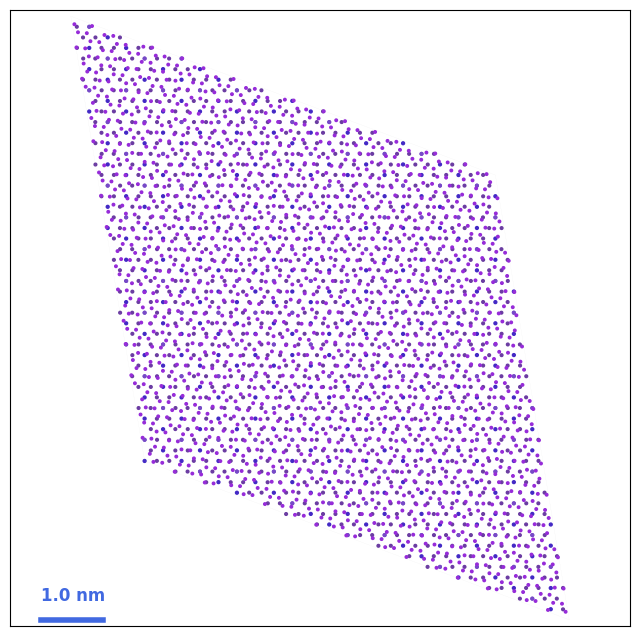

Image address: 'C:\SS\Nook’iin\Nook-iin\Examples\English\Images/FePS3-Grahene24_07-B(3x3).png'


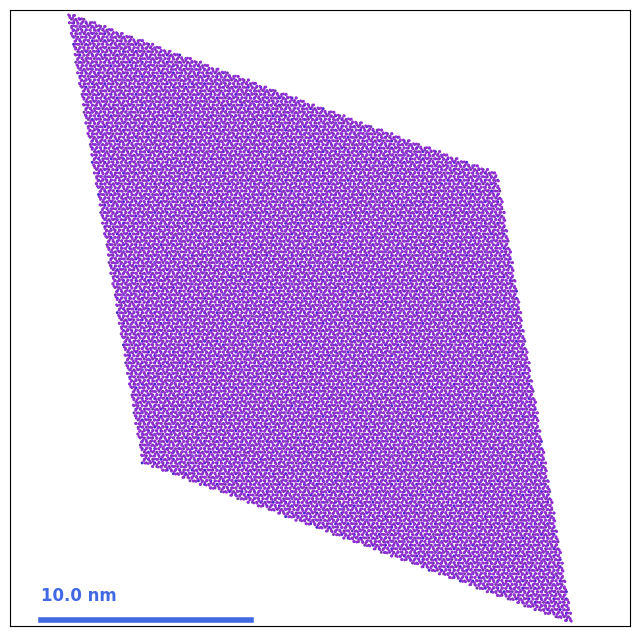

In [7]:
sOp,_ = sr.optimize_system(sr.loMat[9],prnt=False)
sr.leeMT(sr.loMat[9])
sOp.SuperRed.showme(t=1)
sOp.SuperRed.showme(x=3,y=3,t=0.3, iName='FePS3-Grahene24_07-B(3x3)')

### Exporting Result
To export the calculated PC to a POSCAR file, use the export_PC() function.

In [8]:
sMi.exportPC(PCname='FePS3-Grahene24_07(min)')
sOp.exportPC(PCname='FePS3-Grahene24_07(opt)')

Lattice exported in:'C:\SS\Nook’iin\Nook-iin\Examples\English\VASP_Files/FePS3-Grahene24_07(min).vasp'
Lattice exported in:'C:\SS\Nook’iin\Nook-iin\Examples\English\VASP_Files/FePS3-Grahene24_07(opt).vasp'


1

## Reciprocal Space and Diffraction Pattern
With a defined PC, we can generate representations of the reciprocal space and the diffraction pattern.

The representation in reciprocal space consists of a superposition of the FBZs of each lattice forming the system, displayed over a grid formed by the system’s FPZ corresponding to its PC.

To visualize the system’s reciprocal space representation, use the function showReciprocalSpace().

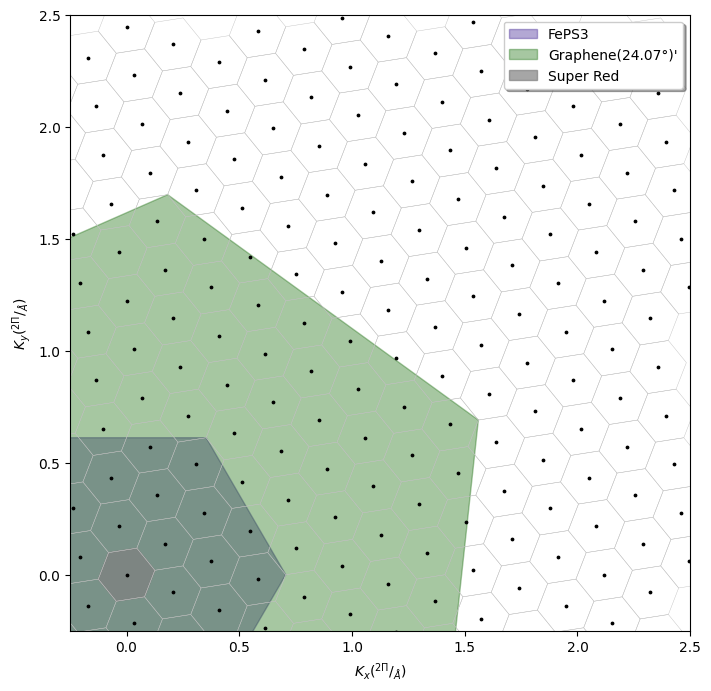

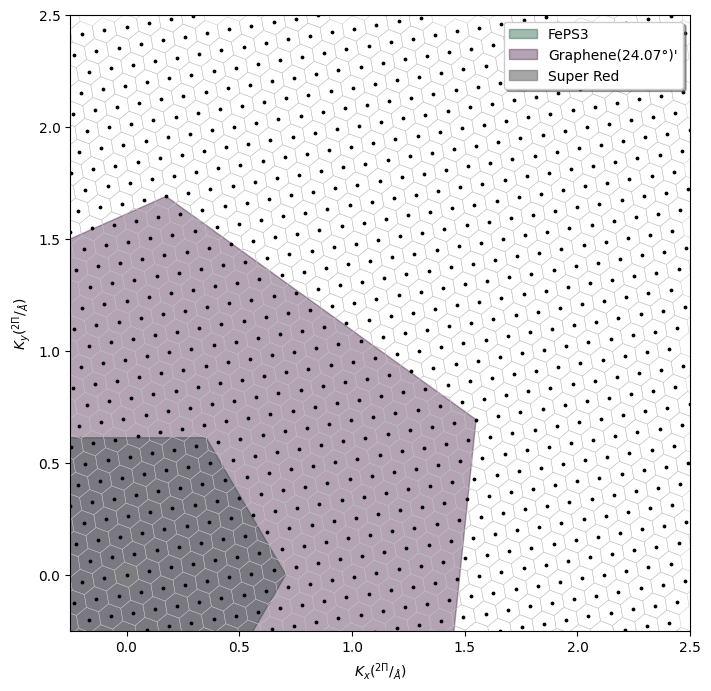

In [9]:
sMi.showReciprocalSpace(t=3,zoom=True)
sOp.showReciprocalSpace(t=3,zoom=True)

To visualize the diffraction pattern, use the function diffractionPattern(). This function may take a few minutes if the PC contains many cells.


Dirección de imagen: '/images/DP-Suggested_System.png'


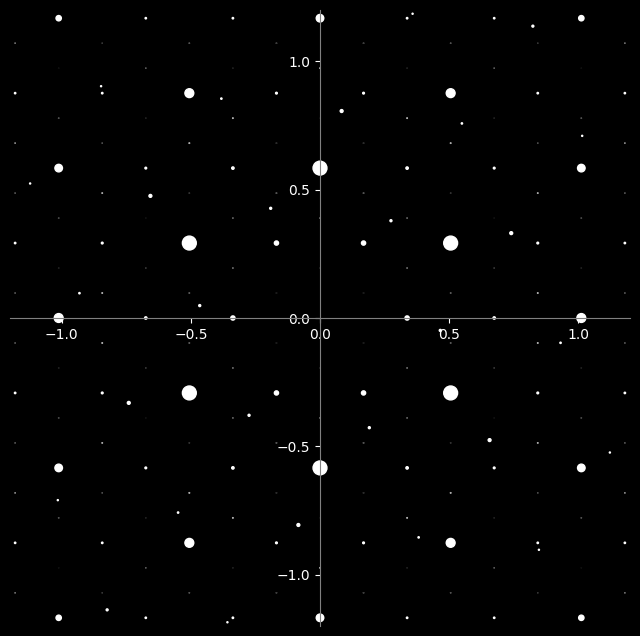


Dirección de imagen: '/images/DP-Minimum_System.png'


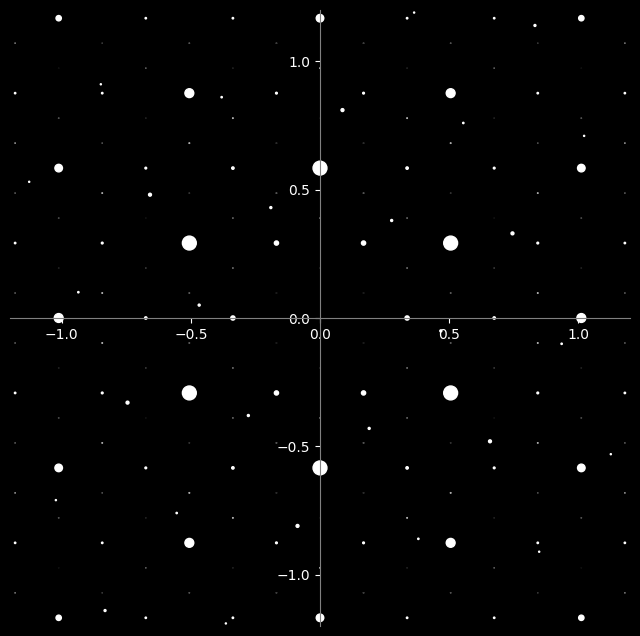

In [10]:
sOp.SuperRed.name="Suggested_System"
sMi.SuperRed.name="Minimum_System"
sOp.diffractionPattern(border=1.2,prnt=True)
sMi.diffractionPattern(border=1.2,prnt=True)